# Convert the data from the processed NC files to H5 for fast readout with py4dstem

 - one has to Upload the Dataset

In [2]:
## install
## need to update pip before installations
import sys
!{sys.executable} -m pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 77.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /home/massmeye/.conda/envs/4dstem/bin/python -m pip install --upgrade pip


In [1]:
## Import all needed functions
import py4DSTEM
from py4dstem_added_functions import *
import matplotlib.pyplot as plt
import mplcyberpunk
import matplotlib 
import numpy as np
from py4Dutils.utils import *

plt.style.use('cyberpunk')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
#need to be set for the interactive GUI
%matplotlib ipympl

In [2]:
## Set paths and correction parameters of your data:

# Example of a gain map:
gain_data = DataParameters(
        data_filepath = r'//masc_shared/ag_volz/pn_data/OM/raw_data/2023_09_22_WS2/gainmap_005/gainmap_005_001.frms6',
        dark_filepath =  r'//masc_shared/ag_volz/pn_data/OM/raw_data/2023_09_22_WS2/dark_IM_FF_006/dark_IM_FF_006_000.frms6',
        save_folder =  r'//masc_shared/ag_volz/pn_data/OM/200kV_gainmaps/', 
        # gain_name = r'GainMap_AB_B1_G004.mat', 
        type = 'data',    #'gain or 'data'. 'gain' will create and save a gainmap to 'save_folder' 
        overwrite = True, # if False, will load data from disk if path exists
        oot_corr = False  # set to False for gainmap
        ) 

# Example of a data set:
data_params = DataParameters(
        data_filepath = r'//masc_shared/ag_volz/pn_data/OM/raw_data/2023_09_22_WS2/HR_EELS_FLAKE_NBD_013/HR_EELS_FLAKE_NBD_013_001.frms6',
        dark_filepath = r'//masc_shared/ag_volz/pn_data/OM/raw_data/2023_09_22_WS2/dark_IM_FF_006/dark_IM_FF_006_000.frms6',
        gain_filepath = r'//masc_shared/ag_volz/pn_data/OM/200kV_gainmaps/GainMap_AB_B1_G004.mat',
        save_folder =   r'//masc_shared/ag_volz/pn_data/OM/converted/WS2/HR_EELS_FLAKE_NBD_013_001.h5', # Your evaluation goes here 
        overwrite = False,  # Will reconvert and overwrite .h5 file and data_params in save_folder if 'True' (loads from these if 'False' and they already exist)
        to_h5 = False,      # When writing on Masc is slow, set to False (saves an uncompressed binary instead)
        oot_corr = True,    # Out of time correction
        t_oot = 23.625,       # int, tuple or 'auto'. 'auto' tries to estimate readout time of top chip from covered pixels. tuple sets different readout times for both chips (top,bottom)
        n_dark = 'all',     # Amount of darkframes to use (can specify int, otherwise 'all')
        n_drop = 200,        # Amount of first dark frames to drop (first dark frames can behave weirdly)
        multiprocess = True # Multiprocess greatly reduces process time, but can be memory intensive. This feature is still experimental -> Turn off if you experience crashes during eval
        )

In [13]:
### If you need to make a gainmap:
gm = load_data(gain_data)

No gain map supplied -> gain set to 1


Loading data:
- Reading dark frames:
-- Read 3896 dark frames
- Correcting frames:
-- Row 156/156  remaining time: 0:00:00
- Writing file to //masc_shared/ag_volz/pn_data/OM/200kV_gainmaps/..
Data loaded in: 0:00:07


In [3]:
## Load Data:
datacube = load_data(data_params)

Loading data:
- Loading from memmap file
Data loaded in: 0:00:00


In [4]:
datacube

DataCube( A 4-dimensional array of shape (512, 512, 248, 248) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [6]:
##stroe the binned datacube
py4DSTEM.save(
    r'//masc_shared/ag_volz/pn_data/OM/converted/WS2/HR_EELS_FLAKE_NBD_013.h5',
    datacube,
    tree = True,  # None to jsut store the datacubes tree
    mode = 'o'    # overwrite mode
)


In [ ]:
datacube = py4DSTEM.read(
    r'//masc_shared/ag_volz/pn_data/OM/converted/WS2/HR_EELS_FLAKE_NBD_013.h5',
)

In [ ]:
#binning

#rebin in realspace to reduce datasize --> 32 GB ram not enough for ptycho of lagre datasets
datacube.bin_R(8)
datacube


In [ ]:
# Get beam size from Vacuum image or from mean dp of dataset to calibrate the data and show pacbed 

#if vacuum ref should be used
if 'datacube_vacuum' in locals():

    #get the mean dp
    probe_vacuum = datacube_vacuum.get_dp_mean()
    
    #calibration
    probe_radius_pixels, probe_qx0, probe_qy0 = datacube_vacuum.get_probe_size(probe_vacuum.data)
    
    #show with determied size as overlay
    center_vacuum = (probe_qx0, probe_qy0)
    
    #with known values:probe step size of 0.26456 Angstroms, probe convergence semiangle of 21 mrads
    datacube_vacuum.calibration.set_R_pixel_size(0.22927)
    datacube_vacuum.calibration.set_R_pixel_units('A')
    datacube_vacuum.calibration.set_Q_pixel_size(21/probe_radius_pixels)
    datacube_vacuum.calibration.set_Q_pixel_units('mrad')
    datacube_vacuum.calibration.set_convergence_semiangle_mrad(21)
    datacube_vacuum.calibration

else:
    # #get the mean dp
    probe = datacube.get_dp_mean()
    
    # #calibration
    probe_radius_pixels, probe_qx0, probe_qy0 = datacube.get_probe_size(probe.data)
    
    #center
    center = (probe_qx0, probe_qy0)

#with known values:probe step size of 0.26456 Angstroms, probe convergence semiangle of 21 mrads
datacube.calibration.set_R_pixel_size(0.26456)
datacube.calibration.set_R_pixel_units('A')
datacube.calibration.set_Q_pixel_size(21/probe_radius_pixels)
datacube.calibration.set_Q_pixel_units('mrad')
datacube.calibration.set_convergence_semiangle_mrad(21)
datacube.calibration

dp_mean = datacube.get_dp_mean()

#show vacuum probe
#if vacuum ref should be used
if 'datacube_vacuum' in locals():
    py4DSTEM.show(
        [probe_vacuum,
         dp_mean],
        show_cbar=True,
        cmap='viridis',
        intensity_range='absolute',
        circle = {'center':center_vacuum,
          'R': probe_radius_pixels,
          'alpha':0.7,
          'fill':False,
          'color':'w',
        },
        vmin=0,
        vmax=100,
        # scaling='lin',
        scalebar = True,
        title = [
            'Mean Diffraction Pattern Vacuum - Probe Size overlayed',
            'Mean Diffraction Pattern  - Probe Size overlayed',
        ],
            
    )
    print("probe_radius_pixels:", probe_radius_pixels, "center_vacuum", center_vacuum)

#
else:
    py4DSTEM.show(
        [probe,
         dp_mean],
        show_cbar=True,
        cmap='viridis',
        intensity_range='absolute',
        circle = {'center':center,
          'R': probe_radius_pixels,
          'alpha':0.7,
          'fill':False,
          'color':'w',
        },
        vmin=0,
        vmax=100,
        # scaling='lin',
        scalebar = True,
        title = [
            'Mean Diffraction Pattern Vacuum - Probe Size overlayed',
            'Mean Diffraction Pattern  - Probe Size overlayed',
        ],
            
    )
    print("probe_radius_pixels:", probe_radius_pixels, "center", center)

In [34]:
# calculate Bright and Dark Field images
expand_BF = 2.0

center = (123.1, 34.7)
center = (132, 132)
radius_BF = probe_radius_pixels
radius_BF = 500
# radii_DF = (probe_radius_pixels + expand_BF, 1e3)

datacube.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
    shift_center = False,
)

# datacube.get_virtual_image(
#     mode = 'annulus',
#     geometry = (center,radii_DF),
#     name = 'dark_field',
#     shift_center = False,
# )

datacube.get_dp_max()


100%|██████████| 4096/4096 [00:00<00:00, 9972.40it/s] 


VirtualDiffraction( A 2-dimensional array of shape (264, 264) called 'dp_max',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

Exception: input argument "ar" has unsupported type <class 'NoneType'>

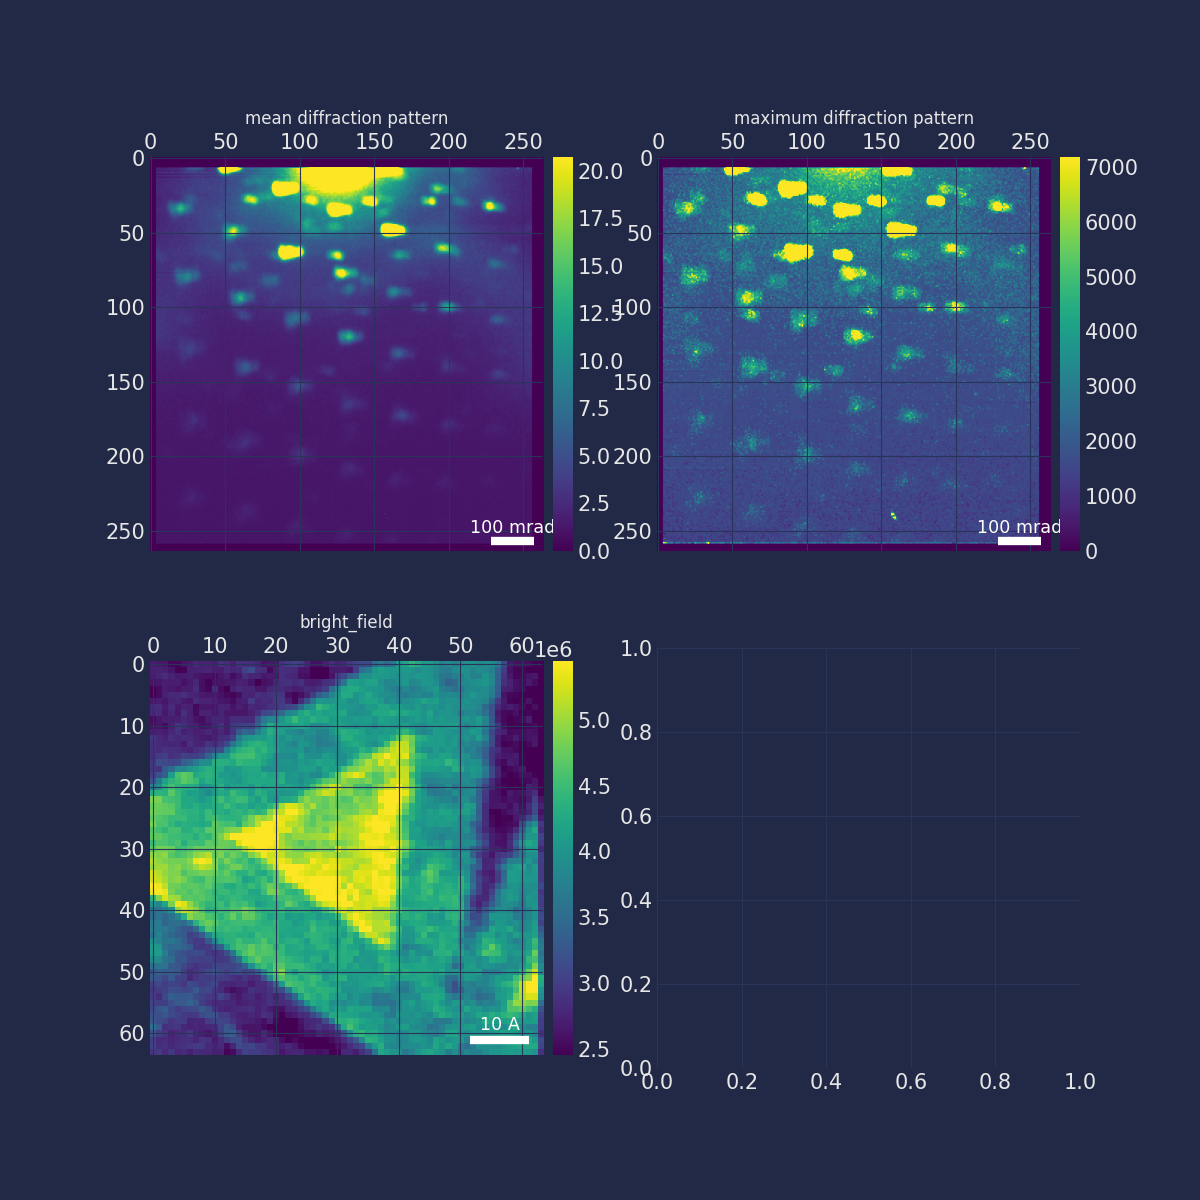

In [35]:
##visualize ---> make output nice

py4DSTEM.show(
    [
       [
           datacube.tree('dp_mean'),
           datacube.tree('dp_max'),
       ],
        [
            datacube.tree('bright_field'),
            # datacube.tree('dark_field'),
        ],
    ],
    show_cbar=True,
    # figax=(fig, axs[0, 0]),
    cmap='viridis',
    scalebar=True,
    title=[
        'mean diffraction pattern',
        'maximum diffraction pattern',
        'bright_field',
        # 'dark_field',
    ],
)


In [14]:
datacube

DataCube( A 4-dimensional array of shape (256, 256, 264, 264) called 'datacube',
          with dimensions:

              Rx = [0.0,0.26456,0.52912,...] A
              Ry = [0.0,0.26456,0.52912,...] A
              Qx = [-26.961255535030798,-23.505626129620683,-20.04999672421057,...] mrad  (*non-linear*)
              Qy = [-151.84457101203543,-148.3889416066253,-144.93331220121522,...] mrad  (*non-linear*)
)

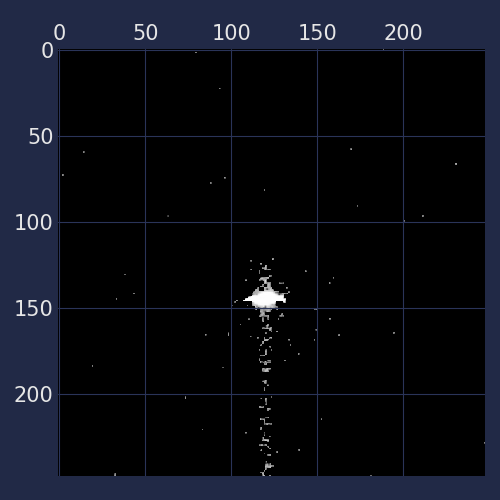

In [8]:
dp = datacube.data[30,30]

py4DSTEM.show(dp,
      scaling = 'log',
         vmin=1,
        vmax=500,
             )